# Imports and General Settings

In [ ]:

import tensorflow as tf

tf.logging.set_verbosity(tf.logging.DEBUG)

import tensorflow.contrib as tf_contrib

import os
import pathlib

import numpy as np

import io

import random

import pylab
import tfplot

import seaborn as sns
import matplotlib.pyplot as plt

import tfx

import tensorflow_transform as tft
%matplotlib inline

from cleverhans.loss import SNNLCrossEntropy

# which GPU to be used (0 is RTX, 1 or 2 are either of the Titan Xps)
gpu = "/GPU:0"

AUTOTUNE = tf.contrib.data.AUTOTUNE

# tf.enable_eager_execution()

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
session_config.allow_soft_placement = True

# session_config.log_device_placement = True
tf.keras.backend.set_session(tf.Session(config=session_config))

# make sure tensorflow-gpu is being used
print(tf.test.gpu_device_name())


# Utility Functions

In [9]:

# Xavier : tf_contrib.layers.xavier_initializer()
# He : tf_contrib.layers.variance_scaling_initializer()
# Normal : tf.random_normal_initializer(mean=0.0, stddev=0.02)
# l2_decay : tf_contrib.layers.l2_regularizer(0.0001)

weight_init = tf_contrib.layers.variance_scaling_initializer()
weight_regularizer = tf_contrib.layers.l2_regularizer(0.0001)


##################################################################################
# Layer
##################################################################################

def conv(x, channels, kernel=4, stride=2, padding='SAME', use_bias=True, scope='conv_0'):
    with tf.variable_scope(scope):
        x = tf.layers.conv2d(inputs=x, filters=channels,
                             kernel_size=kernel, kernel_initializer=weight_init,
                             kernel_regularizer=weight_regularizer,
                             strides=stride, use_bias=use_bias, padding=padding)

        return x

def fully_connected(x, units, use_bias=True, scope='fully_0'):
    with tf.variable_scope(scope):
        x = flatten(x)
        x = tf.layers.dense(x, units=units, kernel_initializer=weight_init, kernel_regularizer=weight_regularizer, use_bias=use_bias)

        return x

def resblock(x_init, channels, kernel=3, is_training=True, use_bias=True, downsample=False, scope='resblock') :
    with tf.variable_scope(scope) :

        x = batch_norm(x_init, is_training, scope='batch_norm_0')
        x = relu(x)

        if downsample :
            x = conv(x, channels, kernel=kernel, stride=2, use_bias=use_bias, scope='conv_0')
            x_init = conv(x_init, channels, kernel=1, stride=2, use_bias=use_bias, scope='conv_init')

        else :
            x = conv(x, channels, kernel=kernel, stride=1, use_bias=use_bias, scope='conv_0')

        x = batch_norm(x, is_training, scope='batch_norm_1')
        x = relu(x)
        x = conv(x, channels, kernel=kernel, stride=1, use_bias=use_bias, scope='conv_1')

        return x + x_init

def bottle_resblock(x_init, channels, is_training=True, use_bias=True, downsample=False, scope='bottle_resblock') :
    with tf.variable_scope(scope) :
        x = batch_norm(x_init, is_training, scope='batch_norm_1x1_front')
        shortcut = relu(x)

        x = conv(shortcut, channels, kernel=1, stride=1, use_bias=use_bias, scope='conv_1x1_front')
        x = batch_norm(x, is_training, scope='batch_norm_3x3')
        x = relu(x)

        if downsample :
            x = conv(x, channels, kernel=3, stride=2, use_bias=use_bias, scope='conv_0')
            shortcut = conv(shortcut, channels*4, kernel=1, stride=2, use_bias=use_bias, scope='conv_init')

        else :
            x = conv(x, channels, kernel=3, stride=1, use_bias=use_bias, scope='conv_0')
            shortcut = conv(shortcut, channels * 4, kernel=1, stride=1, use_bias=use_bias, scope='conv_init')

        x = batch_norm(x, is_training, scope='batch_norm_1x1_back')
        x = relu(x)
        x = conv(x, channels*4, kernel=1, stride=1, use_bias=use_bias, scope='conv_1x1_back')

        return x + shortcut


##################################################################################
# Sampling
##################################################################################

def flatten(x) :
    return tf.layers.flatten(x)

def global_avg_pooling(x):
    gap = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
    return gap

def avg_pooling(x) :
    return tf.layers.average_pooling2d(x, pool_size=2, strides=2, padding='SAME')

def max_pooling(x) :
    return tf.layers.max_pooling2d(x, pool_size=2, strides=2, padding='SAME')


##################################################################################
# Activation function
##################################################################################

def relu(x):
    return tf.nn.relu(x)


##################################################################################
# Normalization function
##################################################################################

def batch_norm(x, is_training=True, scope='batch_norm'):
    return tf_contrib.layers.batch_norm(x,
                                        decay=0.9, epsilon=1e-05,
                                        center=True, scale=True, updates_collections=None,
                                        is_training=is_training, scope=scope)

##################################################################################
# Loss function
##################################################################################

def classification_loss(logit, label) :
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=label, logits=logit))
    prediction = tf.equal(tf.argmax(logit, -1), tf.argmax(label, -1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

    return loss, accuracy


# Loading Data

## Data Augmentation Functions

In [10]:

def rotate(image):
    
    return tf.image.rot90(image, tf.random_uniform(shape=[], minval=0, maxval=4, 
                                               dtype=tf.int32))

def flip(image):
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    return image

def crop(image, range_start=0.8, range_end=1.0):
    
    image = tf.image.central_crop(image, central_fraction=random.uniform(range_start, range_end))
    image = tf.image.resize_images(image,tf.constant([512, 512]))
    return image

def translate(image,  x_max=75, y_max=75):
    
    return tf.contrib.image.translate(image, translations=[random.uniform(-1 * x_max, x_max), 
                                                           random.uniform(-1 * y_max, y_max)])

def augment_image(image):
                       
    image = rotate(image)
    image = flip(image)
    
    image = translate(image)
    image = crop(image)

    return image


## Importing Data

In [11]:
# load an array of image paths
def load_image_paths(path):
    
    data_root = pathlib.Path(path)
    
    # create a list of every file and its label index
    all_image_paths = list(data_root.glob('*/*'))
    all_image_paths = [str(path) for path in all_image_paths]
    
    return all_image_paths

# randomly shuffle train and test values and split based on parameters
def split(image_paths, split=[0.6,0.2,0.2], seed=777):
    random.Random(seed).shuffle(image_paths)
    
    boundary1 = int(len(image_paths) * split[0])
    boundary2 = int(len(image_paths) * (split[0]+split[1]))
    
    train = image_paths[:boundary1]
    evaluate = image_paths[boundary1: boundary2]
    test = image_paths[boundary2:]
    
    return train, evaluate, test

# preprocessing functions
def preprocess_image(image):
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, shape=[512,512])
    image = tf.div(
       tf.subtract(
          image, 
          tf.reduce_min(image)
       ), 
       tf.subtract(
          tf.reduce_max(image), 
          tf.reduce_min(image)
       )
    )
    
    return image

def load_and_preprocess_image(path, training=True):
    image = tf.read_file(path)
    image = preprocess_image(image)
    
    if (training):
        image = augment_image(image[:,:,None])
    
    return image

def load(path, image_paths, training=True, batch_size=64, shuffle=True, drop_remainder=False):
    with tf.device("/CPU:0"):
        # data root
        data_root = pathlib.Path(path)

        # return label names
        label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())

        # assign index to label
        label_to_index = dict((name, index) for index,name in enumerate(label_names))

        # array of all labels corresponding to image_paths
        all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                            for path in image_paths]

        # make path dataset
        path_ds = tf.data.Dataset.from_tensor_slices(image_paths)

        # get image tensors by mapping function over the path dataset
        image_ds = path_ds.map(lambda path : load_and_preprocess_image(path, training=training))

        # create label dataset
        label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

        # zip together image and label dataset into dataset of tuples for
        # estimator input
        image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

        # Setting a shuffle buffer size as large as the dataset ensures that the data is
        # completely shuffled
        
        image_label_ds = image_label_ds.batch(batch_size, drop_remainder=drop_remainder)
        
        if (training):
            print("shuffling and repeating b/c training flag set")

            image_label_ds = image_label_ds.repeat()
        else:
            image_label_ds = image_label_ds.repeat(count=1)
        
        
        if (shuffle):
            image_label_ds = image_label_ds.shuffle(buffer_size = len(image_paths))
            
        # `prefetch` lets the dataset fetch batches, in the background while the model is training.
        image_label_ds = image_label_ds.prefetch(6)
       
        
        return image_label_ds

# ResNet-10

In [12]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    n = X.shape[0]
    d = X.shape[1]
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    
    print("running tsne")
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1
    print(X)
    
    # Initialize variables
    n = X.shape[0]
    d = X.shape[1]
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    Z = [Y[:,0], Y[:,1]]
            
    # Return solution
    return Z
    
class TF_PCA:

    def __init__(self, data, target, dtype=tf.float32):
        self.data = data
        self.target = target

        self.dtype = dtype

    def fit(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.X = tf.placeholder(self.dtype, shape=self.data.shape)
            # Perform SVD
            singular_values, u, _ = tf.svd(self.X)
            # Create sigma matrix
            sigma = tf.diag(singular_values)
        with tf.Session(graph=self.graph) as session:
            self.u, self.singular_values, self.sigma = session.run([u, singular_values, sigma],
                                                                   feed_dict={self.X: self.data})

    def reduce(self, n_dimensions=None, keep_info=None):
        if keep_info:
            # Normalize singular values
            normalized_singular_values = self.singular_values / sum(self.singular_values)
            # Create the aggregated ladder of kept information per dimension
            ladder = np.cumsum(normalized_singular_values)
            # Get the first index which is above the given information threshold
            index = next(idx for idx, value in enumerate(ladder) if value >= keep_info) + 1
            n_dimensions = index
        with self.graph.as_default():
            # Cut out the relevant part from sigma
            sigma = tf.slice(self.sigma, [0, 0], [self.data.shape[1], n_dimensions])
            # PCA
            pca = tf.matmul(self.u, sigma)
        with tf.Session(graph=self.graph) as session:
            return session.run(pca, feed_dict={self.X: self.data})   
        
def pca_tf(X_tensor, Y_tensor):
    
    my_pca = TF_PCA(X_tensor, Y_tensor)
    my_pca.fit()
    
    result = my_pca.reduce(n_dimensions=2)
    print(result.shape)
    
    return result
    
    



## Architecture

In [21]:
num_classes = 3

# ResNet-10 architecture
def resnet10_network(x, conv_kernel=7, resblock_kernel=3, num_channels=4, n_classes=num_classes, reuse = False, is_training = True):
    with tf.variable_scope('Resnet-10', reuse = reuse), tf.device(gpu):
        
        x = tf.reshape(x, shape=[-1, 512, 512, 1])
        # channels
        
        
        
        x = conv(x, num_channels, kernel=conv_kernel, stride=1, padding='SAME')
        
        x = resblock(x, channels=num_channels, kernel=resblock_kernel, is_training=is_training, 
                      downsample=False, scope='resblock_id0')
            
   
        x = resblock(x, channels=num_channels * 2, kernel=resblock_kernel, is_training=is_training, 
                     downsample=True, scope='resblock_conv0')

    
        
        x = resblock(x, channels=num_channels * 2, kernel=resblock_kernel, is_training=is_training, 
                      downsample=False, scope='resblock_id1')
        
  
        
        x = resblock(x, channels=num_channels * 4, kernel=resblock_kernel, is_training=is_training, 
                     downsample=True, scope='resblock_conv1')

    
        
        x = resblock(x, channels=num_channels * 4, kernel=resblock_kernel, is_training=is_training, 
                      downsample=False, scope='resblock_id2')
        
      
        
        x = batch_norm(x, is_training, scope='batch_norm')
        x = relu(x)
        
        x_pre_logits = flatten(x)

        x = fully_connected(x, num_classes)
        
        return x, x_pre_logits

    
def resnet10_model_fn(features, labels, mode, conv_kernel=7, resblock_kernel=3, num_channels=4, snnl_weight=0.05,
                      log=True):
    with tf.device(gpu):

        print("in gpu part")
        logits_train, pre_logits_train = resnet10_network(features,
                                                          conv_kernel=conv_kernel,
                                                          resblock_kernel=resblock_kernel,
                                                          num_channels=num_channels,
                                                          n_classes=num_classes,
                                                          reuse=False,
                                                          is_training=True)

        logits_test, pre_logits_test = resnet10_network(features,
                                                        conv_kernel=conv_kernel,
                                                        resblock_kernel=resblock_kernel,
                                                        num_channels=num_channels,
                                                        n_classes=num_classes,
                                                        reuse=True,
                                                        is_training=False)

        pred_classes = tf.arg_max(logits_test, dimension=1)

        # PREDICT MODE
        if mode == tf.estimator.ModeKeys.PREDICT:

            return tf.estimator.EstimatorSpec(mode=mode, predictions=pred_classes)


        loss_op = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))

        loss_op = (1.0 - snnl_weight) * loss_op + snnl_weight * SNNLCrossEntropy.optimized_temp_SNNL(pre_logits_train,
                                                                                                     labels, 20.0, True)
        acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
        
        tf.summary.scalar("loss", loss_op)
        tf.summary.scalar("accuracy", acc_op[1])
        
        if mode == tf.estimator.ModeKeys.TRAIN:

            # the different ops for training, evaluating, ...
            estim_specs = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=pred_classes,
                loss=loss_op,
                train_op=train_op,
                eval_metric_ops={'accuracy': acc_op}
            )

            return estim_specs



    
#     for var in tf.trainable_variables():
#         print(var.name)
    
    
        conv0_weights = [v for v in tf.global_variables() if v.name == "Resnet-10/conv_0/conv2d/kernel:0"][0]
        print(conv0_weights)



        plot_op = plot_conv_weights(conv0_weights)

        print(plot_op)
        plot_op_expanded = tf.expand_dims(plot_op, 0)
        tf.summary.image("conv_0_weight_plots", plot_op_expanded)

        eval_summary_hook = tf.train.SummarySaverHook(
            save_steps=1,
            output_dir=model_path + "/eval_images",
            summary_op=tf.summary.merge_all())
        # Add it to the evaluation_hook list
        evaluation_hooks = []
        evaluation_hooks.append(eval_summary_hook)

        # the different ops for training, evaluating, ...
        estim_specs = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss_op,
            train_op=train_op,
            eval_metric_ops={'accuracy': acc_op},
            evaluation_hooks=evaluation_hooks
        )

        return estim_specs




            


In [18]:
def prime_powers(n):
    """
    Compute the factors of a positive integer
    Algorithm from https://rosettacode.org/wiki/Factors_of_an_integer#Python
    :param n: int
    :return: set
    """
    factors = set()
    for x in range(1, int(np.sqrt(n)) + 1):
        if n % x == 0:
            factors.add(int(x))
            factors.add(int(n // x))
    return sorted(factors)

def get_grid_dim(x):
    """
    Transforms x into product of two integers
    :param x: int
    :return: two ints
    """
    factors = prime_powers(x)
    if len(factors) % 2 == 0:
        i = int(len(factors) / 2)
        return factors[i], factors[i - 1]

    i = len(factors) // 2
    return factors[i], factors[i]

@tfplot.wrap
def plot_conv_weights(weights, channels_all=True,):
    """
    Plots convolutional filters
    :param weights: numpy array of rank 4
    :param channels_all: boolean, optional

    """
    w_min = np.min(weights)
    w_max = np.max(weights)

    channels = [0]
    # make a list of channels if all are plotted
    if channels_all:
        channels = range(weights.shape[2])

    # get number of convolutional filters
    num_filters = weights.shape[3]

    # get number of grid rows and columns
    grid_r, grid_c = get_grid_dim(num_filters)

    print(grid_r)
    print(grid_c)
    
    # create figure and axes
    fig, axes = plt.subplots(min([grid_r, grid_c]), max([grid_r, grid_c]))

    # iterate channels
    for channel in channels:
        # iterate filters inside every channel
        for l, ax in enumerate(axes.flat):
            # get a single filter
            img = weights[:, :, channel, l]
            # put it on the grid
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
            # remove any labels from the axes
            ax.set_xticks([])
            ax.set_yticks([])
    
    return fig

def pca(X, num_observations=64, n_dimensions = 50):
    singular_values, u, _ = tf.svd(X)
    sigma = tf.diag(singular_values)
    print(sigma)
    
    sigma = tf.slice(sigma, [0, 0], [num_observations, n_dimensions])
    
    pca = tf.matmul(u, sigma)
    pca = tf.transpose(pca)
    return pca

## Experimentation

In [ ]:

tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.005

random_seed = 777

num_steps = 10000

resnet10_checkpoint_path_base = "/data/jma/model/resnet10_kernel_plots/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [7, 9, 5]
filter_sizes = [4]
snnl_weights = [0.0, 0.05, 0.1, 0.2]

data_root = "./data_3classes/"

image_paths = load_image_paths(data_root)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)

train_input_fn = lambda : load(data_root, train_paths, training=True, batch_size=32, shuffle=True)
eval_input_fn = lambda : load(data_root, eval_paths, training=False, batch_size=32, shuffle=False)
test_input_fn = lambda : load(data_root, test_paths, training=False, shuffle=False)

for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight)+"/"
            print(model_path)

            config = tf.estimator.RunConfig(
                log_step_count_steps= 20,
                save_summary_steps= 50,
                save_checkpoints_secs= 120,
                model_dir=model_path,
                tf_random_seed=random_seed,
                session_config=session_config)

            model_fn = lambda features, labels, mode: resnet10_model_fn(features, labels, mode, 
                                                                        conv_kernel=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight)

            model = tf.estimator.Estimator(model_fn=model_fn, config=config)

            train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=num_steps)
            eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, throttle_secs=15)

            tf.estimator.train_and_evaluate(model, train_spec, eval_spec)


        
        

/data/jma/model/resnet10_kernel_plots/kernel7_filter4_snnl0.0/
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/resnet10_kernel_plots/kernel7_filter4_snnl0.0/', '_tf_random_seed': 777, '_save_summary_steps': 50, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 20, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2a74205f98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evalua

## t-SNE

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/resnet10_test/kernel7_filter8_snnl0.0/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb8495d7898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
in gpu part
<tf.Variable 'Resnet-10/conv_0/conv2d/kernel:0' shape=(7,

INFO:tensorflow:Finished evaluation at 2019-07-26-06:14:17
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.546875, global_step = 100, loss = 2.7068906
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /data/jma/model/resnet10_test/kernel7_filter8_snnl0.0/model.ckpt-100


{'accuracy': 0.546875, 'global_step': 100, 'loss': 2.7068906}

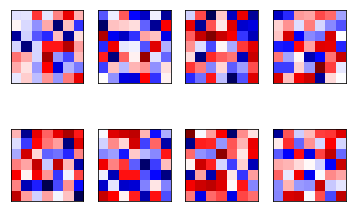

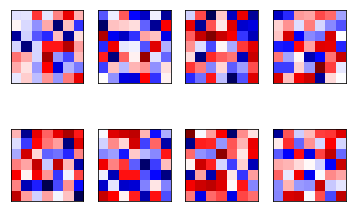

In [177]:
# blue is negative, red is positive
tf.logging.set_verbosity(tf.logging.DEBUG)

kernel_size = 7
filter_size = 8
snnl_weight = 0.0

resnet10_checkpoint_path_base = "/data/jma/model/resnet10_test/"

model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight)+"/"

model_fn = lambda features, labels, mode: resnet10_model_fn(features, labels, mode, 
                                                            conv_kernel=kernel_size, 
                                                            num_channels=filter_size,
                                                            snnl_weight=snnl_weight)

model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)


    
model.evaluate(eval_input_fn)





In [ ]:
        # had to hard code this
#         pca_plt = pca(pre_logits_train, num_observations=64, n_dimensions=2)
        
     
#         print(labels)
    

#     with tf.device("/CPU:0"):
#         color_mapping = {0: sns.xkcd_rgb['bright purple'], 1: sns.xkcd_rgb['lime'], 2: sns.xkcd_rgb['ochre']}
#         keys = list(color_mapping.keys())
#         values = [color_mapping[k] for k in keys]
#         table = tf.contrib.lookup.HashTable(
#             tf.contrib.lookup.KeyValueTensorInitializer(keys, values, key_dtype=tf.int64, value_dtype=tf.string), sns.xkcd_rgb['black']
#         )

#         label_colors = tf.map_fn(lambda x: table.lookup(x), labels, dtype=tf.string)

#         @tfplot.autowrap(figsize=(12, 12))
#         def plot_scatter(x: np.ndarray, y: np.ndarray, colors:np.ndarray, *, ax):
#             ax.scatter(x, y, c=colors)
#             ax.legend()

#         plot_op = plot_scatter(tf.gather_nd(pca_plt, [[0]]), tf.gather_nd(pca_plt, [[1]]), label_colors) 

#         plot_op_expanded = tf.expand_dims(plot_op, 0)

#         tf.summary.image("pca", plot_op_expanded)

['data_3classes/0/c87f27a1-0a60-4208-b0e0-dd5b36b46754.png', 'data_3classes/1/1ee92fad-dab7-4ea2-a970-c5b10dbb2278.png', 'data_3classes/2/2633fb78-cfef-4d57-853a-6010a5484bf1.png', 'data_3classes/0/ef3db06b-3150-41d9-a0a0-8743c613702a.png', 'data_3classes/0/3eddc491-c7f6-4736-b69f-0582b3f42e2c.png', 'data_3classes/2/c5b8f0bb-1a2e-4134-a7ec-5515b401337c.png', 'data_3classes/0/129d0d39-67cf-4acf-9581-f98b273d5288.png', 'data_3classes/1/39caa510-25c6-43ab-96e7-36ba3bca62ce.png', 'data_3classes/1/723e0ee6-194a-40c7-8def-494a84825ec6.png', 'data_3classes/1/c5c3a3ae-8725-4b90-9d8d-044edd5cd692.png', 'data_3classes/1/50b2f70c-b140-49ad-b0b0-5344b91d2af9.png', 'data_3classes/1/dc3becc6-86ee-40a8-a681-1e874e963ec1.png', 'data_3classes/1/3c458adb-39a7-497a-a770-8a8f46d04321.png', 'data_3classes/1/ccf4871d-a6ca-4ea9-a213-e4036ed2a2dc.png', 'data_3classes/0/fb783f95-c2a8-49cb-9b7d-df6503a5472d.png', 'data_3classes/1/5f6b531b-9163-415d-99fb-c9b96dd2b36a.png', 'data_3classes/2/071be6a8-a8f1-4da1-b61